# Seismic Cubeset and CropBatch tutorial

This notebook demonstrates how to work with `SeismicDataset`, which is merely a container for `Field` instances, and shows pipeline of loading actual data into batches. You will learn how to:

- organize loads of cubes and horizons into one entity
- generate points close to one of the horizons in 3D cube space
- load seismic images and create masks near generated points
- apply augmentations for both data and labels

In [1]:
%load_ext autoreload
%autoreload 2

# All the necessary imports
import sys
import numpy as np
from glob import glob

sys.path.insert(0, '..')
from batchflow import D, P, R, FilesIndex, Pipeline
from seismiqb import SeismicDataset, Horizon, SeismicSampler, plot 

# Seismic Dataset

As was mentioned before, an instance of `SeismicDataset` is merely a container to hold field (cubes, horizons, etc.) together. It is initialized from a dict of cube paths mapped to relative path to horizons (or other labels), and under the hood instances of `SeismicGeometry` are created:

In [2]:
cubes = {'/data/seismic_data/seismic_interpretation/002_M/002_M.qblosc': '~/INPUTS/HORIZONS/FINAL/*'}

dataset = SeismicDataset(index=cubes, labels_class=Horizon)

print(dataset)

Seismic Dataset with 1 field:
    Field `002_M` with processed geometry and labels:
        - labels: [t0_G_anon, t0_M_anon, t0_BV8_anon, t0_B_anon, t0_J1_anon]



As we can see, now each field knows about its cube and labels, as well as lots of other statistics which you can check in [the very first tutorial on `SeismicGeometry`](./01_Geometry.ipynb).

The last but not least, sampler. Sampler is an entity that generates points in following format:

- each point is 9-dimensional:
    - the first two entries are indices of the cube and horizons that this point belongs to;
    - the third is an index of axis to make a crop along;
    - the next three are start coordinates of the crop;
    - the last three are end coordinates of the crop;
- by default, horizons sampler generates points close to the set of the horizons for each cube.

During the model train, we sample points and use it as anchor for crop location, that is cut from actual seismic cube. Method `show_sampled` allows to visualize actually generated crops of data given the shape of desired crops:

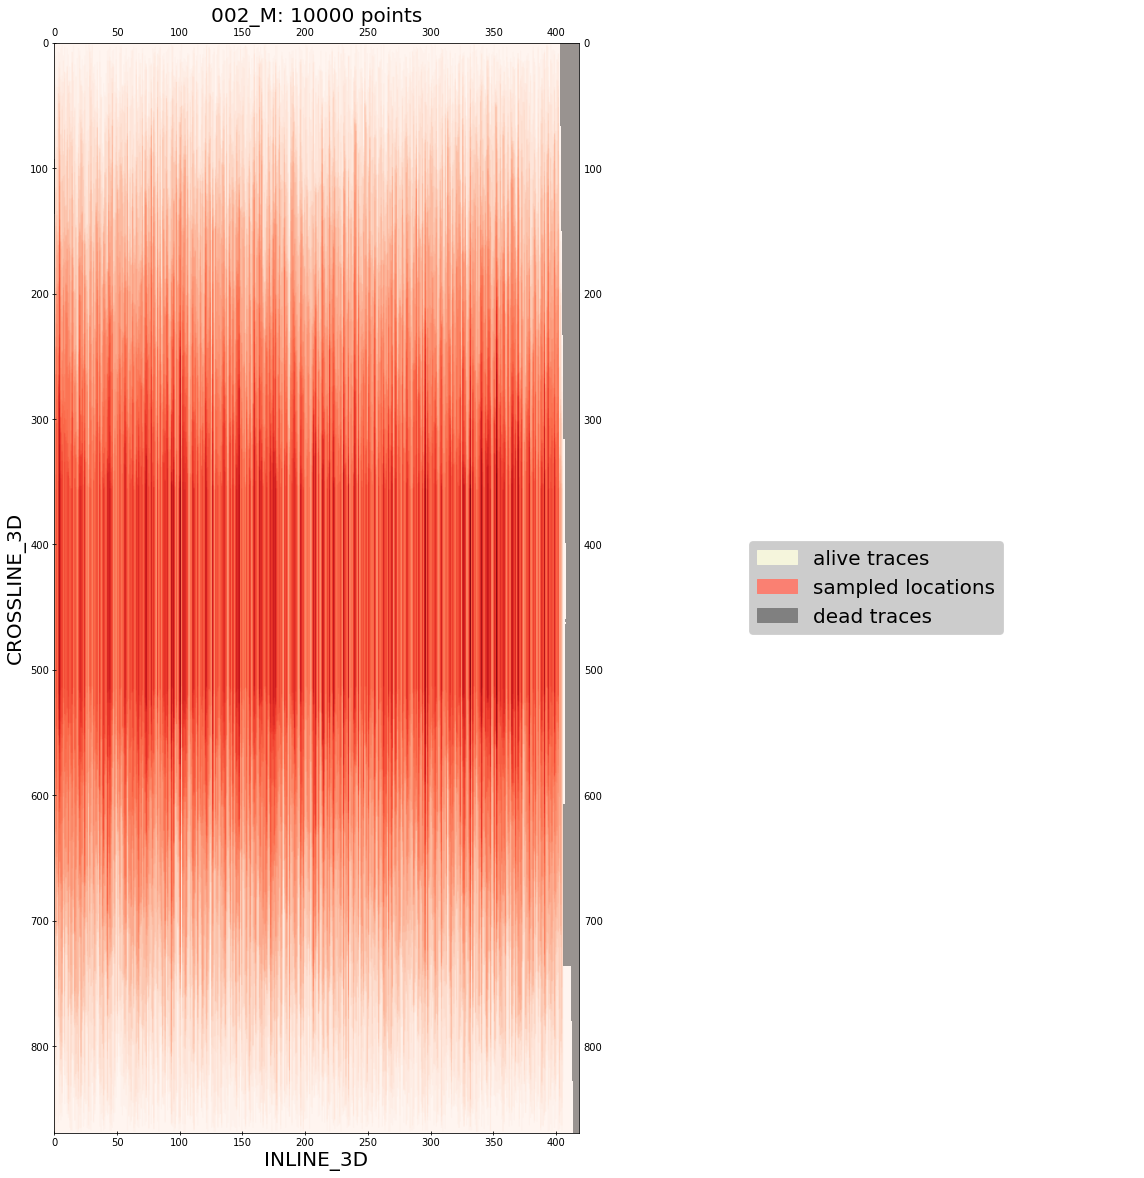

In [3]:
sampler = SeismicSampler(labels=dataset.labels, crop_shape=(1, 512, 512), mode='horizon')

sampler.show_sampled()

# CropBatch

All of our research is organized with the help of [**BatchFlow** library](https://github.com/analysiscenter/batchflow), which allows us to:

- define pipelines that set the sequence of actions to be performed on generated batches of data. Each action can be done in a multi-threading or multi-processing way, where different threads/processes work with various individual batch items
- create complex neural networks with just a few lines of code
- do hyperparameter research 

To load data according to sampler, we:
- create crop locations, based on generated (sampled) points of desired shape. Note that it does not load anything from disk: only positions are created

- heavy lifting of disk I/O is performed by `load_cubes`, that takes positions (created by `make_locations`) and actually gets seismic data

- `create_masks` action generates segmentation mask for the crop location by adding all of the horizons on it

In [4]:
demo_pipeline = (
    Pipeline()
    .make_locations(generator=sampler, batch_size=16)
    .load_cubes(dst='images')
    .create_masks(dst='masks', width=5)
) << dataset

batch = demo_pipeline.next_batch()

All the created components (`images`, `masks`) can be accessed via dotted notation: `batch.images` and `batch.masks`. Following visualization shows them on separate graphs:

In [5]:
batch.show_roll(n=5, components=[['images', 'masks']])

In order to train a robust model, we must diversify our dataset with wealth of data augmentations: that helps to prevent overfitting and make model generalize better to unseen inputs. Many of the augmentations are already implemented as part of `CropBatch`:

* `transpose`: by default, `crop`, `load_cubes`, `create_mask` get data in `(iline, xline, h)` format with `iline` being used as image-channel, yet most of the following augmentations can be computed way more efficiently if the channel axis is the last. Transposing allows us to permute the order before applying augmentations
* `scale`: as different cubes have different ranges of possible values, it is usually a good idea to transform each of them to a fixed range. Under the hood, minimum and maximum values for each cube are used
* `additive_noise`, `multiplicative_noise`: modify each entry in `src` by adding zero-mean noise or multiplying by values with mean at 1

#### All of the next augmentations are applied to the first two axes, so `rotate_axis` is what you want to do before them!
* `rotate`, `scale_2d`: rotate image around its center, zoom in or zoom out of it
* `cutout_2d`: zero-out patches of first two axes
* `affine_transform`, `perspective_transform`: change basis to move 3 (4 in case of perspective transform) points to different location 
* `elastic_transform`: slightly jitter the indexing grid of the first two axes of `src`
* `bandwidth_filter`: keep only desired range of frequences

In [6]:
keep_coords = [
    'images', 'masks',
    'images_anoise',
    'images_mnoise',
    'images_cutout',
    'images_bfilter',
]

transform_coords = [
    'images_rotate', 'masks_rotate',
    'images_scale', 'masks_scale',
    'images_affine', 'masks_affine',
    'images_perspective', 'masks_perspective',
    'images_elastic_hard', 'masks_elastic_hard',
    'images_elastic_soft', 'masks_elastic_soft',
]

to_binarize = [item for item in transform_coords if item.startswith('masks')] # masks will be transformed and [0, 1]-values will be corrupted.

demo_pipeline = (
    Pipeline()
    # Load data
    .make_locations(generator=sampler, batch_size=16)
    .load_cubes(dst='images')
    .create_masks(dst='masks', width=5)
    .normalize(src='images')
    .adaptive_reshape(src=['images', 'masks'])
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    
    # Images only augmentations:
    .additive_noise(scale=0.05,
                    src='images', dst='images_anoise')
    .multiplicative_noise(scale=0.05,
                          src='images', dst='images_mnoise')
    .cutout_2d(patch_shape=P(R('uniform', 10, 20, size=2)), n_patches=P(R('uniform', 10, 20)),
               src='images', dst='images_cutout')
    .bandwidth_filter(lowcut=0.09, highcut=0.5, fs=2,
                      src='images', dst='images_bfilter')

    # Images and masks augmentations: 
    .rotate(angle=P(R('uniform', 5, 30)), adjust=True,
            src=['images', 'masks'], dst=['images_rotate', 'masks_rotate'])
    .scale_2d(scale=2,
              src=['images', 'masks'], dst=['images_scale', 'masks_scale'])
    .affine_transform(alpha_affine=P(R('uniform', 0, 30)),
                      src=['images', 'masks'], dst=['images_affine', 'masks_affine'])
    .perspective_transform(alpha_persp=P(R('uniform', 0, 30)),
                           src=['images', 'masks'], dst=['images_perspective', 'masks_perspective'])
    .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], dst=['images_elastic_hard', 'masks_elastic_hard'])
    .elastic_transform(alpha=P(R('uniform', 20, 25)), sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], dst=['images_elastic_soft', 'masks_elastic_soft'])
    
    .transpose(src=keep_coords + transform_coords, order=(2, 0, 1))
    .binarize(src=to_binarize)
) << dataset

batch = demo_pipeline.next_batch(D('size'))

Seismic data and its augmented counterpart:

In [7]:
augmentations = ['anoise', 'mnoise', 'cutout', 'bfilter']
components = [f'images_{aug}' for aug in augmentations]

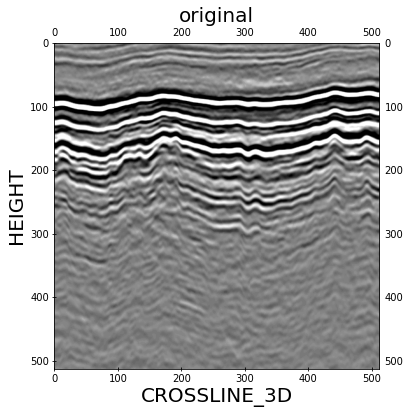

In [8]:
batch.show_roll(indices=[0], components=['images'], ncols=1, title='original')
batch.show_roll(indices=[0], components=components, title=augmentations, ncols=4)

Seismic data with masks painted over it and the augmented counterpart:

In [9]:
augmentations = ['rotate', 'scale', 'affine', 'perspective', 'elastic_hard', 'elastic_soft']
components = [[f'images_{aug}', f'masks_{aug}'] for aug in augmentations]

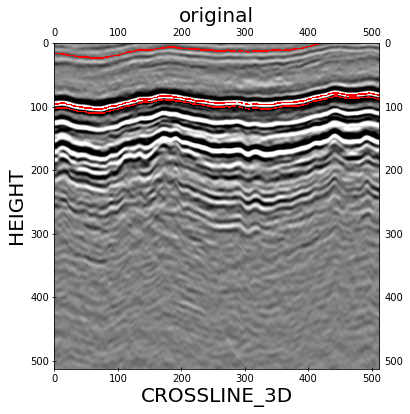

/opt/conda/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([vmin, vmax], dtype=scaled_dtype)


In [10]:
batch.show_roll(indices=[0], components=[['images', 'masks']], ncols=1, title='original')
batch.show_roll(indices=[0], components=components, ncols=3, title=augmentations)